In [1]:
from keras.preprocessing.text import Tokenizer
from numpy import array
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# source text
data = """ Jack and Jill went up the hill\n
 To fetch a pail of water\n
 Jack fell down and broke his crown\n
 and Jill came tumbling after\n """

## Model 1: one-word-in, one-word-out seq

Given one word as input, the model will learn to predict the next word in the sequence.


In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0]

vocab_size = len(tokenizer.word_index) + 1
print(f'vocab_size: {vocab_size}')

vocab_size: 22


In [4]:
sequences = [encoded[i-1: i+1] for i in range(1, len(encoded))]
print(f'Total Sequences: {len(sequences)}')
sequences = array(sequences)

X, y = sequences[:, 0], sequences[:, 1]
y = to_categorical(y, num_classes=vocab_size)

Total Sequences: 24


In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             220       
                                                                 
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dense (Dense)               (None, 22)                1122      
                                                                 
Total params: 13542 (52.90 KB)
Trainable params: 13542 (52.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=100, verbose=2)

Epoch 1/100
1/1 - 3s - loss: 0.6139 - accuracy: 0.8750 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 0.6089 - accuracy: 0.8750 - 8ms/epoch - 8ms/step
Epoch 3/100
1/1 - 0s - loss: 0.6039 - accuracy: 0.8750 - 8ms/epoch - 8ms/step
Epoch 4/100
1/1 - 0s - loss: 0.5989 - accuracy: 0.8750 - 8ms/epoch - 8ms/step
Epoch 5/100
1/1 - 0s - loss: 0.5940 - accuracy: 0.8750 - 12ms/epoch - 12ms/step
Epoch 6/100
1/1 - 0s - loss: 0.5891 - accuracy: 0.8750 - 8ms/epoch - 8ms/step
Epoch 7/100
1/1 - 0s - loss: 0.5843 - accuracy: 0.8750 - 12ms/epoch - 12ms/step
Epoch 8/100
1/1 - 0s - loss: 0.5795 - accuracy: 0.8750 - 12ms/epoch - 12ms/step
Epoch 9/100
1/1 - 0s - loss: 0.5748 - accuracy: 0.8750 - 8ms/epoch - 8ms/step
Epoch 10/100
1/1 - 0s - loss: 0.5701 - accuracy: 0.8750 - 12ms/epoch - 12ms/step
Epoch 11/100
1/1 - 0s - loss: 0.5655 - accuracy: 0.8750 - 12ms/epoch - 12ms/step
Epoch 12/100
1/1 - 0s - loss: 0.5609 - accuracy: 0.8750 - 8ms/epoch - 8ms/step
Epoch 13/100
1/1 - 0s - loss: 0.5564 - accuracy: 0.87

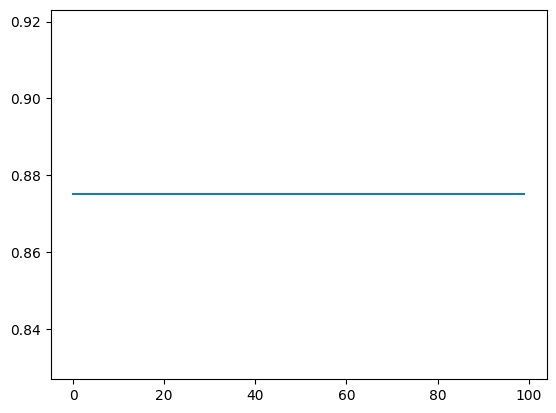

In [8]:
plt.plot(history.history['accuracy'])

In [11]:
import numpy as np
import random

in_text = random.choice(list(tokenizer.word_index.keys()))
print(f'in_text : {in_text}')

seq = array(tokenizer.texts_to_sequences([in_text])[0])
yhat = model.predict_on_batch([seq])
out_text = tokenizer.index_word[np.argmax(yhat)]
print(f'out_text: {out_text}')

in_text : fell
out_text: down


In [12]:
def gen_seq(model, tokenizer, seed_text, n_words):
    in_text, res = seed_text, seed_text
    for _ in range(n_words):
        seq = array(tokenizer.texts_to_sequences([in_text])[0])
        yhat = model.predict_on_batch([seq])
        out_text = tokenizer.index_word[np.argmax(yhat)]
        in_text, res = out_text, res + ' ' + out_text

    return res

In [23]:
in_text = random.choice(list(tokenizer.word_index.keys()))

next_pre_seq = gen_seq(model, tokenizer, in_text, 5)
print(f'next seq:', next_pre_seq)

next seq: fell down and jill came tumbling


In [24]:
def gen_next_word(model, tokenizer, seed_text, n_words):

    seq = array(tokenizer.texts_to_sequences([seed_text])[0])
    yhat = model.predict_on_batch([seq])

    out_text = [tokenizer.index_word[i]
                for i in np.argsort(yhat)[0][::-1][:n_words]]

    return out_text

In [34]:
print(data)

 Jack and Jill went up the hill

 To fetch a pail of water

 Jack fell down and broke his crown

 and Jill came tumbling after
 


In [37]:
in_text = random.choice(list(tokenizer.word_index.keys()))

most_porp_next_word = gen_next_word(model, tokenizer, in_text, 5)
print(
    f'Top 5 most prop for next words after <{in_text}>: {most_porp_next_word}')

Top 5 most prop for next words after <jill>: ['came', 'went', 'down', 'jill', 'broke']


## Model 2: Line-by-Line Sequence


In [38]:
from keras.preprocessing.sequence import pad_sequences

sequences = []

for line in data.split('\n'):
    
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequences.append(encoded[:i+1])

print('Total Sequences: %d' % len(sequences))

Total Sequences: 21


In [39]:
max_len = max([len(s) for s in sequences])
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
sequences = array(sequences)
print('Max Sequence Length: %d' % max_len)

Max Sequence Length: 7


In [40]:
X, y = sequences[:, :-1], sequences[:, -1]
y = to_categorical(y, num_classes=vocab_size)

In [41]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_len-1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=300, verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 6, 10)             220       
                                                                 
 lstm_1 (LSTM)               (None, 50)                12200     
                                                                 
 dense_1 (Dense)             (None, 22)                1122      
                                                                 
Total params: 13542 (52.90 KB)
Trainable params: 13542 (52.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/300
1/1 - 3s - loss: 3.0914 - accuracy: 0.0476 - 3s/epoch - 3s/step
Epoch 2/300
1/1 - 0s - loss: 3.0899 - accuracy: 0.0952 - 12ms/epoch - 12ms/step
Epoch 3/300
1/1 - 0s - loss: 3.0883 - accuracy: 0.0952 - 12ms/epoch - 12ms/step
Epoch 4/300
1/1 - 0s - loss: 3.0868 - acc

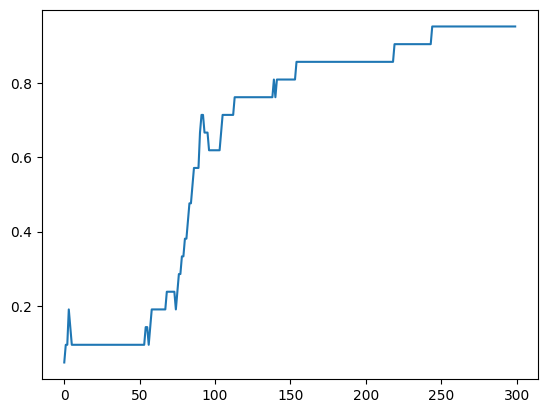

In [42]:
plt.plot(history.history['accuracy'])

In [43]:
def gen_seq(model, tokenizer, max_len, seed_text, n_words):

    for _ in range(n_words):

        seq = array(tokenizer.texts_to_sequences([seed_text])[0])
        seq = pad_sequences([seq], maxlen=max_len-1, padding='pre')

        yhat = model.predict_on_batch([seq])

        seed_text += ' ' + tokenizer.index_word[np.argmax(yhat)]

    return seed_text

In [44]:
print(data)

 Jack and Jill went up the hill

 To fetch a pail of water

 Jack fell down and broke his crown

 and Jill came tumbling after
 


In [56]:
in_text = random.choice(list(tokenizer.word_index.keys()))

print(gen_seq(model, tokenizer, max_len, in_text, 2))

the fetch a


## Model 3: Two-Words-In, One-Word-Out Sequence


In [57]:
def make_train_seq_prev_words(text, n_pervw=1):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([text])
    encoded = tokenizer.texts_to_sequences([text])[0]

    sequences = array([encoded[i-n_pervw: i+1]
                      for i in range(n_pervw, len(encoded))])

    return sequences[:, :-1], to_categorical(sequences[:, -1], num_classes=len(tokenizer.word_index)+1), tokenizer, n_pervw+1

In [58]:
X, y, tok, maxlen = make_train_seq_prev_words(data, 2)

In [69]:
def make_model(X, y, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_len-1))
    model.add(LSTM(50))
    model.add(Dense(vocab_size, activation='softmax'))
    print(model.summary())

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    history = model.fit(X, y, epochs=300, verbose=2).history
    return model, history

In [70]:
model, history = make_model(X, y, maxlen)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2, 10)             220       
                                                                 
 lstm_3 (LSTM)               (None, 50)                12200     
                                                                 
 dense_3 (Dense)             (None, 22)                1122      
                                                                 
Total params: 13542 (52.90 KB)
Trainable params: 13542 (52.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/300
1/1 - 2s - loss: 3.0907 - accuracy: 0.0435 - 2s/epoch - 2s/step
Epoch 2/300
1/1 - 0s - loss: 3.0898 - accuracy: 0.0000e+00 - 5ms/epoch - 5ms/step
Epoch 3/300
1/1 - 0s - loss: 3.0888 - accuracy: 0.0870 - 3ms/epoch - 3ms/step
Epoch 4/300
1/1 - 0s - loss: 3.0879 - acc

In [71]:
def gen_top_next_word(model, tokenizer, max_len, seed_text, n_words):

    seq = array(tokenizer.texts_to_sequences([seed_text])[0])
    seq = pad_sequences([seq], maxlen=max_len-1, padding='pre')

    yhat = model.predict_on_batch([seq])

    out_text = [tokenizer.index_word[i]
                for i in np.argsort(yhat)[0][::-1][:n_words]]

    return out_text

In [72]:
print(data)

 Jack and Jill went up the hill

 To fetch a pail of water

 Jack fell down and broke his crown

 and Jill came tumbling after
 


In [79]:
gen_top_next_word(model, tok, maxlen, 'Jack love', 2)

['jill', 'down']

In [276]:
gen_seq(model, tok, maxlen, 'Jill went', 3)

'Jill went up the hill'